<a href="https://colab.research.google.com/github/Fantajim/AI_assignment/blob/master/Assignment_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

This section takes care all matters concerning the data:

- We start by loading the ARFF file and converting it into a Pandas DataFrame.
- Decode the data to UTF-8 to remove the 'b' that was previously visible
- And then we start to manipulate the dataframe to fit our needs:

yes/no --> become 0/1

the three risk classes will be converted to Integers 0/1/2

All data values from the column "disease" will have their own separate column with either 0 or 1 in case if the original column had this disease listed.

The Dataframe gets divided into the training features and the corresponding training labels. 

The features will then get normalized to jumpstart the model, so that it works with values that are between [0-1] and doesnt waste epochs on normalizing it itself.

Optionally one can either generate an overall statistic of the data or a Seaborn plot to get an overview of the data by uncommenting the respective lines of code. The seaborn output can be found below:

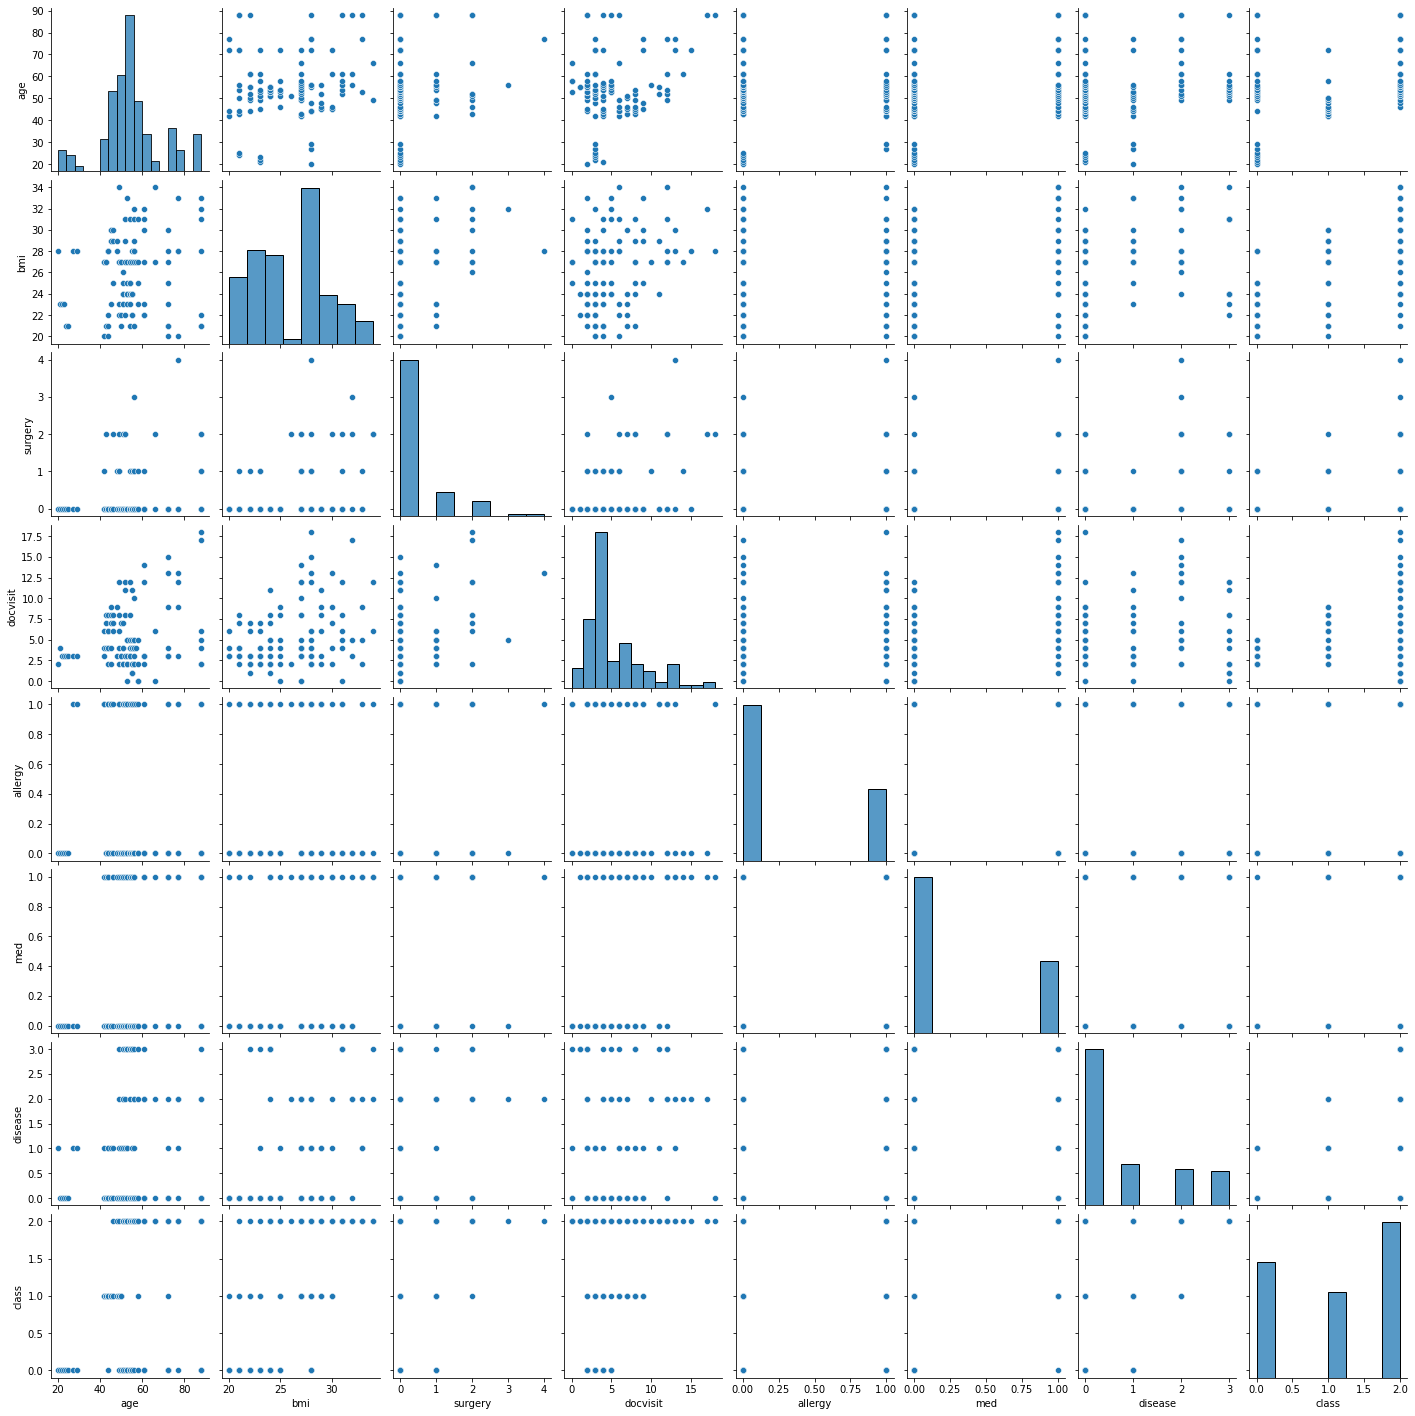


In [ ]:
from scipy.io import arff
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

## Mount GDrive
drive.mount("/content/drive")

## Data time

# Initialize Scaler
scaler = MinMaxScaler()

# Load Data
data = arff.loadarff('/content/drive/My Drive/AI stuff/Project_Learning.arff')

# Transform into Pandas Dataframe
df = pd.DataFrame(data[0])

# decode object columns into String
for cols in df.columns[df.dtypes == object]:
    df[cols] = df[cols].str.decode('utf-8')

# Map yes/no to 0/1
df["med"] = df["med"].map(dict(yes=1, no=0))
df["allergy"] = df["allergy"].map(dict(yes=1, no=0))

# Map "class" label to integer
df["class"] = df["class"].map(dict(low=0, medium=1, high=2))

# Map diseases to integers
df["disease"] = df["disease"].map(dict(no=0, cholesterol=1, diabetes=2, heart=3))

# Prepare training/label data
train_features = df.copy().astype("float32")
train_labels = train_features.pop("class")

# [OPTIONAL] see overview of row/cols
#print(train_data)

# [OPTIONAL]Show overall statistics
#print(train_features.describe().transpose())
#print(train_features)

# [OPTIONAL] Show plot
#plot = sns.pairplot(df[["age", "bmi", "surgery", "docvisit", "allergy", "med", "disease", "class"]])
#plt.show()


# Model

In this section we firstly setup the early stopper parameters, so that we later have an exit point when the model starts to overfit.

We then define the Input/Hidden/Output layers of the model, with additional Flatten layers so that the previous layer gets transformed into a 1 dimensional array.

The optimizer is "Adam" because adam seems to combine several good features from other optimizers.

Lastly we fit the model and define that 20% of the data should be used as validation. The Shuffle parameter true will shuffle all the training data to also theoretically counteract overfitting (Unsure if this really helps in this case).


In [ ]:
import json
import random
## Model time
options = ["Single", "Loop static Layers", "Loop and pray to RNGesus", "Refine model"]
########################################################################
### General setup parameters
## set desired mode
#option[0] will just generate and save a model with our default static layers in a single run
#option[1] will loop for the set amount of tries and find a better model, then save it
#option[2] will loop to find a better model... but every layer is random (pure chaos -> pretty bad but interesting)
#option[3] will load the weights from the former best model and preloads a new model with them (must have same tensor structure)
#
#Change the mode here:
mode = options[0]

# Set the amount of trial runs (Ignored for option[0])
tries = 25

#Specify the path of the model folder (Edit this to an existing folder on your Google Drive)
folder_name = "/content/drive/My Drive/AI stuff/best_insurance_model"

###Keras parameters
##Change the model parameters here
#layers (These are our default tensor values) -> layers with 0/False are ignored by the model
layer1 = 7
layer2 = 14
layer3 = 0
dropout1 = 0
dropout2 = 0
dropout3 = 0
flatten1 = False
flatten2 = False

#model fit
batch = 10
validation_split = 0.1
shuffle = True
callback_patience = 10

########################################################################

# Initialize and configure EarlyStopper
# Callback -> to stop when model starts to overfit. Thats why we can mostly ignore the high epoch amount we are gonna set
early_stop = EarlyStopping(monitor='val_loss', patience=callback_patience)

# Utility function to save model in Gdrive with history data in json format
def save_model(trained_model, trained_model_history):

  #json save
  data = {}
  data['accuracy'] = trained_model_history.history['accuracy']
  data['val_accuracy'] = trained_model_history.history['val_accuracy']
  data['loss'] = trained_model_history.history['loss']
  data['val_loss'] = trained_model_history.history['val_loss']
  with open(f"{folder_name}/model_history.txt", "w") as out:
   json.dump(data, out)

  #model save
  trained_model.save(filepath=folder_name)

#Utility function to prepare and run models
def setup_model(weights=None):
    global layer1
    global layer2
    global layer3
    global dropout1
    global dropout2
    global dropout3
    global flatten1
    global flatten2

    #Initialize Model
    model = keras.Sequential()

    #randomize tensors if enabled
    if mode==options[2]:
      layer1 = random.randint(1, 100)
      layer2 = random.randint(1, 100)
      layer3 = random.randint(1, 100)
      dropout1 = random.uniform(0, 0.5)
      dropout2 = random.uniform(0, 0.5)
      dropout3 = random.uniform(0, 0.5)
      flatten1 = random.choice([True, False])
      flatten2 = random.choice([True, False])

    #define model
    model.add(layers.Flatten(input_shape=train_features.shape[1:])),

    model.add(layers.Dense(hidden_layer1, activation="relu"))
    if dropout1 > 0: model.add(layers.Dropout(hidden_dropout1))
    if flatten1 is True: model.add(layers.Flatten())

    if layer2 > 0: model.add(layers.Dense(hidden_layer2, activation="relu"))
    if dropout2 > 0: model.add(layers.Dropout(hidden_dropout2))
    if flatten2 is True: model.add(layers.Flatten())

    if layer3 > 0: model.add(layers.Dense(hidden_layer3, activation="relu"))
    if dropout3 > 0: model.add(layers.Dropout(hidden_dropout3)) 

    model.add(layers.Dense(3, activation="softmax"))

    if mode==options[3]: model.set_weights(weights)

    #compile model
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

    #fit model
    model_history= model.fit(x=train_features, y=train_labels, batch_size=batch, epochs=500,
          validation_split=validation_split, shuffle=shuffle, verbose=0, callbacks=[early_stop])
    #return model and its history
    return model, model_history

if mode != options[0]:
  #open former json history file
  with open(f"{folder_name}/model_history.txt") as file:
    former_best_history = json.load(file)

  former_best_weights = None
  if mode == options[3]:
    former_best_model = keras.models.load_model(folder_name)
    former_best_weights = former_best_model.get_weights()

  for int in range(tries):
    #create a model and its history
    trained_model, trained_model_history = setup_model(former_best_weights)

    #Check if the created model has better validation loss than the stored one
    if former_best_history["val_loss"][-1] > trained_model_history.history["val_loss"][-1]:
    
      #Print the model validation loss along with a summary
      print(f"Found better model with a val_loss of {trained_model_history.history['val_loss'][-1]}")
      print(f"Found better model with a val_accuracy of {trained_model_history.history['val_accuracy'][-1]}")

      print(trained_model.summary())

      #Save the model/history to Gdrive
      save_model(trained_model, trained_model_history)

      #Update the current best history for the remaining loops
      with open(f"{folder_name}/model_history.txt") as file:
        former_best_history= json.load(file)

    else:
      print(f"no luck.. Throwing the dice again")

else:
  trained_model, trained_model_history = setup_model()
  save_model(trained_model, trained_model_history)

INFO:tensorflow:Assets written to: /content/drive/My Drive/AI stuff/best_insurance_model/assets


# Plotting

Here we plot training vs validation of accuracy and loss in a seperate plot.

We also show the final values that the model has achieved in that learning phase.

Lastly, a general summary of the model is printed.

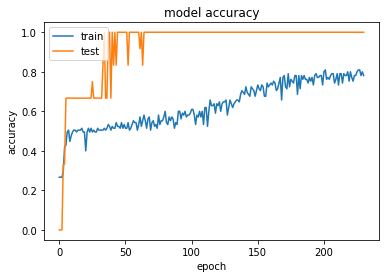

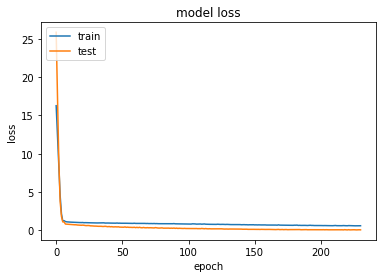

last validation accuracy:  [1.0]
last validation loss:  [0.06640782207250595] 

Model: "sequential_1476"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1685 (Flatten)       (None, 7)                 0         
_________________________________________________________________
dense_4772 (Dense)           (None, 7)                 56        
_________________________________________________________________
dense_4773 (Dense)           (None, 14)                112       
_________________________________________________________________
dense_4774 (Dense)           (None, 3)                 45        
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Plotting time
#Read data from the model folder
best_model = keras.models.load_model(folder_name)
with open(f"{folder_name}/model_history.txt") as file:
  best_history = json.load(file)

# accuracy plot
plt.plot(best_history['accuracy'])
plt.plot(best_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(best_history['loss'])
plt.plot(best_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Print the final model values
print("last validation accuracy: ",best_history['val_accuracy'][-1:])
print("last validation loss: ",best_history['val_loss'][-1:], "\n")

best_model.summary()